# Feature Engineering

Now we need to somehow put all data from different files in one and prepare it for the modelling. Let's see how it can be done.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.mad import MAD
from scipy.stats import normaltest
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set()
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from imports import *
import gc

In [2]:
app_train=pd.read_csv('../data/application_train.csv')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637.0000,-3648.0000,-2120,NaN,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188.0000,-1186.0000,-291,NaN,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225.0000,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Governmen

It's common knowledge that feature engineering is king. Hence, even if this part may be a bit tediuos and not as fun as building models, you probably won't be able to get a really great model without it. After FE (especially automatic FE), lots of new features will be added to the dataset. Obviously, not all of them will be useful in the model. So, we must do feature selection to keep 'best' features.

Except for main `application_train.csv` file, there are 6 files with different data about an applicant. Hence, we can't ignore these files and must incorporate data from them too. But before that, let's create some domain knowledge-based features.

## Domain features

These are features that one thinks of because of some prior knowledge/experience in the area (you just know that they make sense, can help to distinquish good and bad applicants). Also there will be some features that are not knowledge-based, but just seems at least a bit promising. 
\
NOTE: I'm going to add lots of features, but most of them will be removed during feature selection. Here I'll just try out different combinations/ratios that may work (and hope for the best).

In [3]:
def generate_domain_features(data):
    print(f'Before adding features: {data.shape}')
    df=data.copy()

    # CREDIT related 
    bins=[18, 35, 40, 50, 60, 70, 120]
    labels=['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
    df['NEW_AGE_GROUP']=pd.cut(df['DAYS_BIRTH']/-365, bins=bins, labels=labels, right=False)

    cred_by_contract=df.groupby('NAME_CONTRACT_TYPE')['AMT_CREDIT'].mean() 
    cred_by_housing_type=df.groupby('NAME_HOUSING_TYPE')['AMT_CREDIT'].mean() 
    cred_by_org_type=df.groupby('ORGANIZATION_TYPE')['AMT_CREDIT'].mean() 
    cred_by_education_type=df.groupby('NAME_EDUCATION_TYPE')['AMT_CREDIT'].mean() 
    cred_by_gender=df.groupby('CODE_GENDER')['AMT_CREDIT'].mean() 
    cred_by_family_status=df.groupby('NAME_FAMILY_STATUS')['AMT_CREDIT'].mean()
    cred_by_age_group=df.groupby('NEW_AGE_GROUP')['AMT_CREDIT'].mean()

    df['NEW_AMT_CREDIT_TO_AMT_INCOME']=df['AMT_CREDIT']/df['AMT_INCOME_TOTAL'] 
    df['NEW_AMT_CREDIT_TO_AMT_ANNUITY']=df['AMT_CREDIT']/df['AMT_ANNUITY']
    df['NEW_AMT_CREDIT_TO_AMT_GOODS_PRICE']=df['AMT_CREDIT']/df['AMT_GOODS_PRICE']
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_CONTRACT_TYPE']=df['AMT_CREDIT']/(df['NAME_CONTRACT_TYPE'].map(cred_by_contract))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_HOUSING_TYPE']=df['AMT_CREDIT']/(df['NAME_HOUSING_TYPE'].map(cred_by_housing_type))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_ORGANIZATION_TYPE']=df['AMT_CREDIT']/(df['ORGANIZATION_TYPE'].map(cred_by_org_type))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_EDUCATION_TYPE']=df['AMT_CREDIT']/(df['NAME_EDUCATION_TYPE'].map(cred_by_education_type))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_GENDER']=df['AMT_CREDIT']/(df['CODE_GENDER'].map(cred_by_gender))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_FAMILY_STATUS']=df['AMT_CREDIT']/(df['NAME_FAMILY_STATUS'].map(cred_by_family_status))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_INCOME_BY_AGE_GROUP']=df['AMT_CREDIT']/df['NEW_AGE_GROUP'].map(cred_by_age_group)


    # INCOME related
    inc_by_contract=df.groupby('NAME_CONTRACT_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_housing_type=df.groupby('NAME_HOUSING_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_org_type=df.groupby('ORGANIZATION_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_education_type=df.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean() 
    inc_by_gender=df.groupby('CODE_GENDER')['AMT_INCOME_TOTAL'].mean()
    inc_by_family_status=df.groupby('NAME_FAMILY_STATUS')['AMT_INCOME_TOTAL'].mean()
    inc_by_age_group=df.groupby('NEW_AGE_GROUP')['AMT_INCOME_TOTAL'].mean()

    df['NEW_AMT_INCOME_BY_AGE_GROUP']=df['AMT_INCOME_TOTAL']/df['NEW_AGE_GROUP'].map(inc_by_age_group)
    df['NEW_AMT_INCOME_BY_CNT_CHILD']=df['AMT_INCOME_TOTAL']/(1+df['CNT_CHILDREN'])
    df['NEW_AMT_INCOME_BY_CNT_FAM_MEMBERS']=df['AMT_INCOME_TOTAL']/df['CNT_FAM_MEMBERS']
    df['NEW_AMT_INCOME_BY_AGE']=df['AMT_INCOME_TOTAL']/(df['DAYS_BIRTH']/-365)
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_CONTRACT_TYPE']=df['AMT_INCOME_TOTAL']/(df['NAME_CONTRACT_TYPE'].map(inc_by_contract))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_HOUSING_TYPE']=df['AMT_INCOME_TOTAL']/(df['NAME_HOUSING_TYPE'].map(inc_by_housing_type))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_ORGANIZATION_TYPE']=df['AMT_INCOME_TOTAL']/(df['ORGANIZATION_TYPE'].map(inc_by_org_type))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_EDUCATION_TYPE']=df['AMT_INCOME_TOTAL']/(df['NAME_EDUCATION_TYPE'].map(inc_by_education_type))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_CREDIT_BY_GENDER']=df['AMT_INCOME_TOTAL']/(df['CODE_GENDER'].map(inc_by_gender))
    df['NEW_AMT_CREDIT_TO_MEAN_AMT_CREDIT_BY_FAMILY_STATUS']=df['AMT_CREDIT']/(df['NAME_FAMILY_STATUS'].map(inc_by_family_status))
    df['NEW_AMT_INCOME_TO_MEAN_AMT_INCOME_BY_AGE_GROUP']=df['AMT_INCOME_TOTAL']/df['NEW_AGE_GROUP'].map(inc_by_age_group)


    # FLAG related
    # doc_flags--20 columns about documents
    # contact_flags--6 flags about contact info of client (FLAG_MOBIL, FLAG_EMAIL, etc)
    # address_flags--6 flags about address info of client (REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, etc)
    doc_flags=[i for i in df.columns if 'FLAG_DOCUMENT' in i]
    contact_flags=[i for i in df.columns if ('FLAG' in i) and (i not in doc_flags) and (i not in ('FLAG_OWN_CAR', 'FLAG_OWN_REALTY'))]
    address_flags=[i for i in df.columns if 'NOT' in i]
    flag_map={'Y':1, 'N':0}

    df['NEW_DOC_FLAG_MEAN']=df[doc_flags].mean(axis=1)
    df['NEW_DOC_FLAG_SUM']=df[doc_flags].sum(axis=1)
    df['NEW_CONTACT_FLAG_MEAN']=df[contact_flags].mean(axis=1)
    df['NEW_CONTACT_FLAG_SUM']=df[contact_flags].sum(axis=1)
    df['NEW_ADDRESS_FLAG_MEAN']=df[address_flags].mean(axis=1)
    df['NEW_ADDRESS_FLAG_SUM']=df[address_flags].sum(axis=1)
    df['NEW_OWN_CAR_REALTY_COMBINATION']=0.75*df['FLAG_OWN_REALTY'].map(flag_map)+0.25*df['FLAG_OWN_CAR'].map(flag_map)


    # AGE related
    age_by_housing_type=df.groupby('NAME_HOUSING_TYPE')['DAYS_BIRTH'].mean()
    age_by_own_realty=df.groupby('FLAG_OWN_REALTY')['DAYS_BIRTH'].mean()
    age_by_own_car=df.groupby('FLAG_OWN_CAR')['DAYS_BIRTH'].mean()

    df['NEW_AGE_TO_MEAN_AGE_BY_FLAG_OWN_REALTY']=df['DAYS_BIRTH']/(df['FLAG_OWN_REALTY'].map(age_by_own_realty))
    df['NEW_AGE_TO_MEAN_AGE_BY_FLAG_OWN_CAR']=df['DAYS_BIRTH']/(df['FLAG_OWN_CAR'].map(age_by_own_car))
    df['NEW_AGE_TO_MEAN_AGE_BY_HOUSING_TYPE']=df['DAYS_BIRTH']/(df['NAME_HOUSING_TYPE'].map(age_by_housing_type))
    df["NEW_DAYS_EMPLOYED_TO_DAYS_BIRTH"]=df['DAYS_EMPLOYED']/df['DAYS_BIRTH']
    df["NEW_DAYS_REGISTRATION_TO_DAYS_BIRTH"]=df['DAYS_REGISTRATION']/df['DAYS_BIRTH']


    # Other
    df['NEW_OWN_CAR_AGE_TO_DAYS_BIRTH']=df['OWN_CAR_AGE']/df['DAYS_BIRTH']
    df['NEW_OWN_CAR_AGE_TO_DAYS_EMPLOYED']=df['OWN_CAR_AGE']/df['DAYS_EMPLOYED']
    df['NEW_DAYS_LAST_PHONE_CHANGE_TO_DAYS_BIRTH']=df['DAYS_LAST_PHONE_CHANGE']/df['DAYS_BIRTH']
    df['NEW_DAYS_LAST_PHONE_CHANGE_TO_DAYS_EMPLOYED']=df['DAYS_LAST_PHONE_CHANGE']/df['DAYS_EMPLOYED']
    df['NEW_CNT_CHILD_TO_CNT_FAM_MEMBERS']=df['CNT_CHILDREN']/df['CNT_FAM_MEMBERS']
    df['NEW_EXT_SOURCES_MEAN']=df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_EXT_SOURCES_STD']=df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_DAYS_CHANGE_MEAN']=df[['DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION']].mean(axis=1)
    df['NEW_REGION_RATING_CLIENT_MEAN']=df[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].mean(axis=1)
    df['NEW_30_CNT_SOCIAL_CIRCLE_MEAN']=df[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE']].mean(axis=1)
    df['NEW_60_CNT_SOCIAL_CIRCLE_MEAN']=df[['OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']].mean(axis=1)
    
    print(f'After adding features: {df.shape}')
    return df

In [4]:
app_train_domain=generate_domain_features(app_train)

Before adding features: (307511, 122)
After adding features: (307511, 166)


Original dataframe got bigger by 35% (in columns). That's a lot of new features. Let's quickly test do they really add any value? I'll use LightGBM and 5-fold stratified CV to compare performance on original and new dataframes. For this reason I'll wrote a function that in which data is splitted in folds, each fold is passed through `ColumnTransformer` (in which categorical features got one-hot-encoded and numerical ones don't change at all) and AUC on noth train and validation (hold-out) fold are returned. Also, I've kept track of feature importance in order to see whether created features will be among most important ones.

In [5]:
def custom_lgbm_cv(features, target, col_tran, k=5):
    metric_df=pd.DataFrame(columns=['Train AUC', 'Test AUC'])
    feat_importances=[]
    kfold=StratifiedKFold(k)
    for f, (tr, te) in enumerate(kfold.split(features, y=target)):
        X_train, y_train=features.iloc[tr, :], target.iloc[tr]
        X_test, y_test=features.iloc[te, :], target.iloc[te]

        X_train_tr=col_tran.fit_transform(X_train)
        X_test_tr=col_tran.transform(X_test)
        weight=np.count_nonzero(y_train==0)/np.count_nonzero(y_train==1)

        params={'num_boost_round': 10000,
                'objective': 'binary',
                'scale_pos_weight': weight,
                'metric': 'auc',
                'learning_rate': 0.05,
                'reg_alpha': 0.1,
                'reg_lambda': 0.1,
                'subsample': 0.8,
                'n_jobs': -1,
                'random_state': 5,
                'verbose': -1}

        dtrain=lgb.Dataset(X_train_tr, label=y_train)
        dval=lgb.Dataset(X_test_tr, label=y_test)

        model=lgb.train(
                params=params,
                train_set=dtrain,
                valid_sets=[dtrain, dval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(100, verbose=-1), lgb.log_evaluation(-1)])
        
        test_score, train_score=model.best_score['test']['auc'], model.best_score['train']['auc']
        metric_df.loc[f]=[train_score, test_score]

        feat_importances.append(model.feature_importance(importance_type='gain'))
    
    feat_importances=np.array(feat_importances).mean(axis=0)
    feat_importances_df=pd.DataFrame({'feature': col_tran.get_feature_names_out(),
                                        'importance': feat_importances})
    metric_df.loc['Avg']=[metric_df['Train AUC'].mean(), metric_df['Test AUC'].mean()]
    return metric_df, feat_importances_df

In [6]:
def quick_cv(df):
    X, y=df.drop(['TARGET', 'SK_ID_CURR'], axis=1), df['TARGET']
    cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns

    ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
    col_tr=ColumnTransformer([
        ('cat', ohe, cat_cols),
        ('num', 'passthrough', num_cols)
    ])

    res, importances=custom_lgbm_cv(X, y, col_tr)
    return res, importances

res, importances=quick_cv(app_train)
res

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	train's auc: 0.808445	test's auc: 0.760279
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	train's auc: 0.812351	test's auc: 0.759453
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	train's auc: 0.80685	test's auc: 0.752092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[271]	train's auc: 0.81132	test's auc: 0.762341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	train's auc: 0.817154	test's auc: 0.760744


,Train AUC,Test AUC
0,0.8084,0.7603
1,0.8124,0.7595
2,0.8068,0.7521
3,0.8113,0.7623
4,0.8172,0.7607
Avg,0.8112,0.7590


In [7]:
def plot_feat_imp(df, num_feat=10):
    df=df.sort_values(by='importance', ascending=False)
    df['importance_normalized']=round(df['importance']/df['importance'].sum(), 3)
    plt.figure(figsize=(12, 8))
    g=sns.barplot(orient='horizontal', y='feature', x='importance_normalized', data=df.iloc[:num_feat,], color='blue', edgecolor='k')
    plt.ylabel('')
    plt.xlabel('Importance normalized')
    plt.title(f'{num_feat} Most Important Features', size=24)

    for i in g.containers:
        g.bar_label(i,)

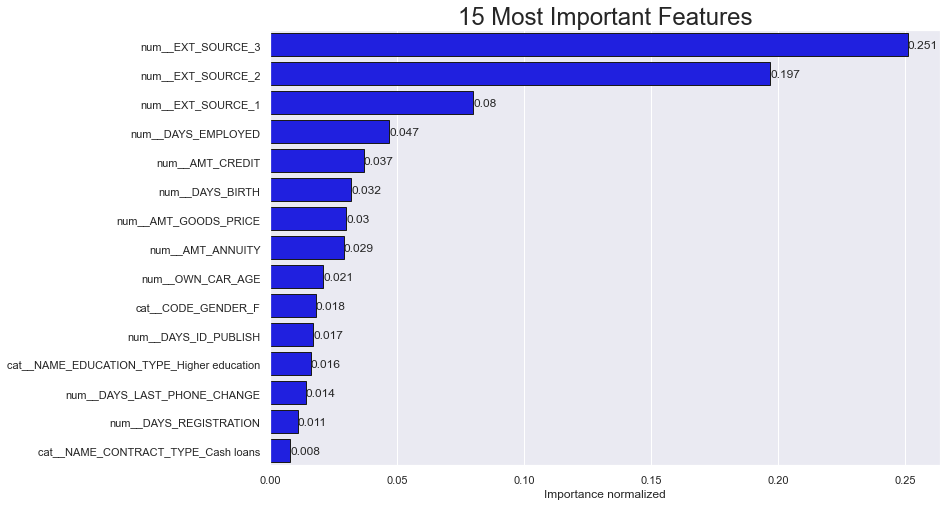

In [8]:
plot_feat_imp(importances, 15)

In [9]:
res_dom, importances_dom=quick_cv(app_train_domain)
res_dom

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	train's auc: 0.819241	test's auc: 0.765529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's auc: 0.815432	test's auc: 0.767875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	train's auc: 0.815636	test's auc: 0.759884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	train's auc: 0.809496	test's auc: 0.767089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	train's auc: 0.821598	test's auc: 0.768517


,Train AUC,Test AUC
0,0.8192,0.7655
1,0.8154,0.7679
2,0.8156,0.7599
3,0.8095,0.7671
4,0.8216,0.7685
Avg,0.8163,0.7658


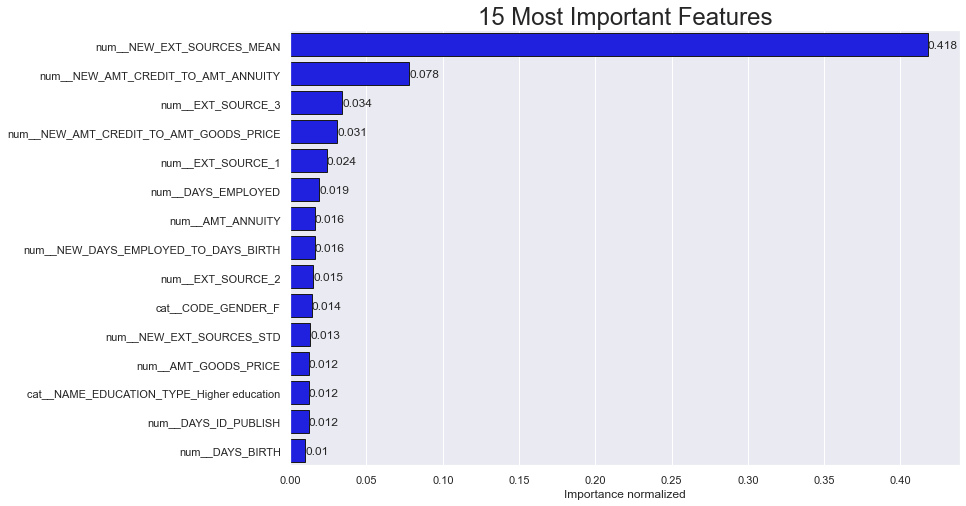

In [10]:
plot_feat_imp(importances_dom, 15)

In [11]:
import gc

gc.enable()
del app_train
gc.collect()

11013

Indeed, without even any Feature Selection, both train and test AUC improved. Moreover, there are newly generated features among most important ones. We're heading to the right direction! Now it's time to incorporate data from other sources to train set. 

## Bureau and Bureau Balance

We start with `bureau.csv` and `bureau_balance.csv`. These dataset scontain information about client's previous credits and  monthly data about them. Let's import the data and explore it.

In [15]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [16]:
bur=pd.read_csv('../data/bureau.csv')
bb=pd.read_csv('../data/bureau_balance.csv')

In [17]:
bur, bb=convert_types(bur, print_info=True), convert_types(bb, print_info=True)

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.13 gb.
Original Memory Usage: 0.66 gb.
New Memory Usage: 0.35 gb.


In [18]:
bur.shape, bb.shape

((1716428, 17), (27299925, 3))

There is **a lot** of rows, but few columns. The reason why these sets have so much records is because one loan in the application can have multiple previous credits and a single previous credit can have multiple rows in BB. It's application-->bureau-->bb. Hence, we need to aggregate data in `bureau_balance.csv` to 'stick' it to `bureau.csv` and then aggregate that bureau-bb combination to attach it to `application_train.csv`. These kind of aggregations is what we will deal with from now on with the rest of datasets. Seems like a lot, but a couple of defined functions will be reused each time. So, let's get started!

In [19]:
bur.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,NaN,0,91323.0000,0.0000,NaN,0.0000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0000,NaN,NaN,0,225000.0000,171342.0000,NaN,0.0000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0000,NaN,NaN,0,464323.5000,NaN,NaN,0.0000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0000,NaN,NaN,0.0000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0000,NaN,77674.5000,0,2700000.0000,NaN,NaN,0.0000,Consumer credit,-21,NaN


In [20]:
bur.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   SK_ID_CURR              1716428 non-null  int32   
 1   SK_ID_BUREAU            1716428 non-null  int32   
 2   CREDIT_ACTIVE           1716428 non-null  category
 3   CREDIT_CURRENCY         1716428 non-null  category
 4   DAYS_CREDIT             1716428 non-null  int64   
 5   CREDIT_DAY_OVERDUE      1716428 non-null  int64   
 6   DAYS_CREDIT_ENDDATE     1610875 non-null  float32 
 7   DAYS_ENDDATE_FACT       1082775 non-null  float32 
 8   AMT_CREDIT_MAX_OVERDUE  591940 non-null   float32 
 9   CNT_CREDIT_PROLONG      1716428 non-null  int64   
 10  AMT_CREDIT_SUM          1716415 non-null  float32 
 11  AMT_CREDIT_SUM_DEBT     1458759 non-null  float32 
 12  AMT_CREDIT_SUM_LIMIT    1124648 non-null  float32 
 13  AMT_CREDIT_SUM_OVERDUE  1716428 non-null  

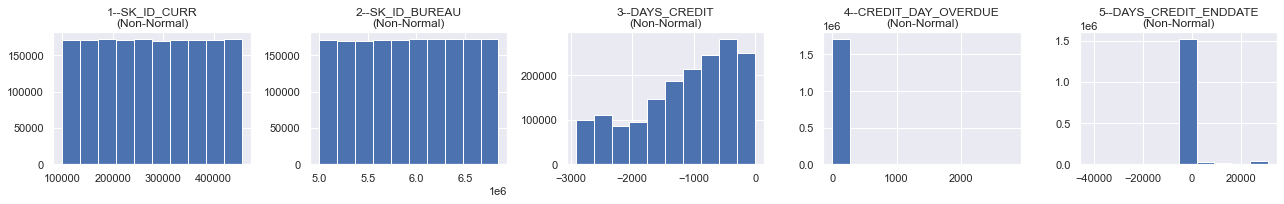

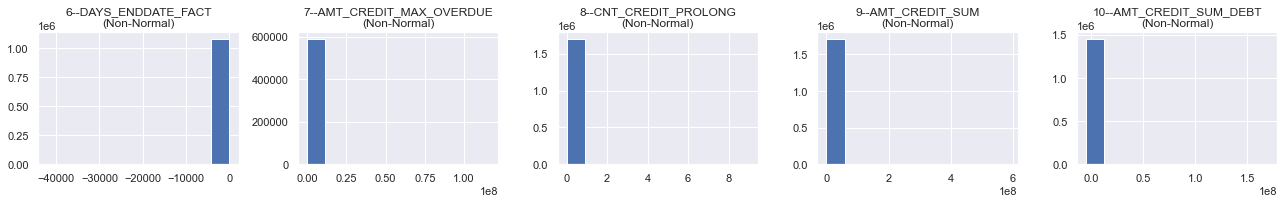

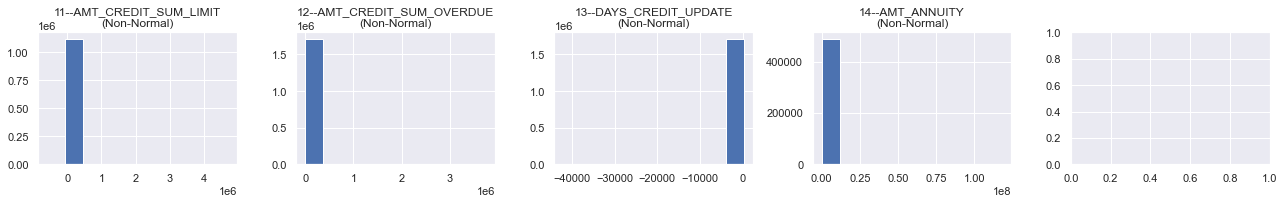

In [21]:
from imports import *

num_cols_bureau=list(bur.select_dtypes('number').columns)

plot_numeric(bur, num_cols_bureau, 5)

Not so informative, because there are huge outliers.

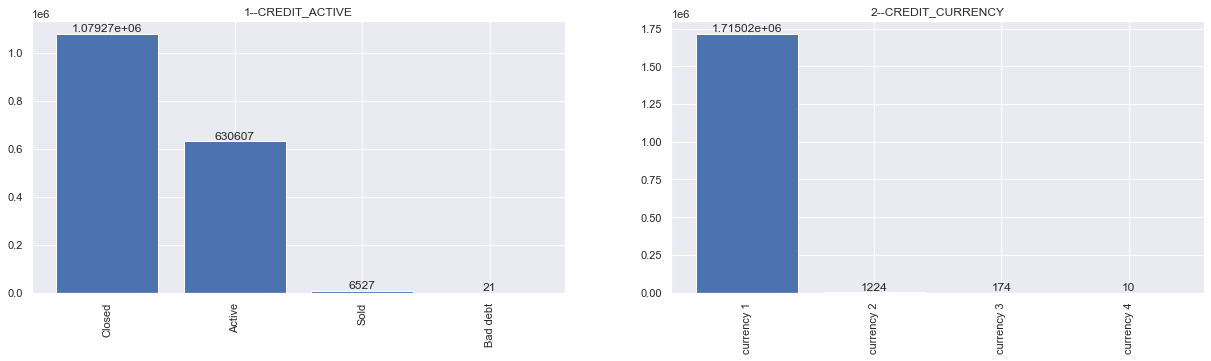

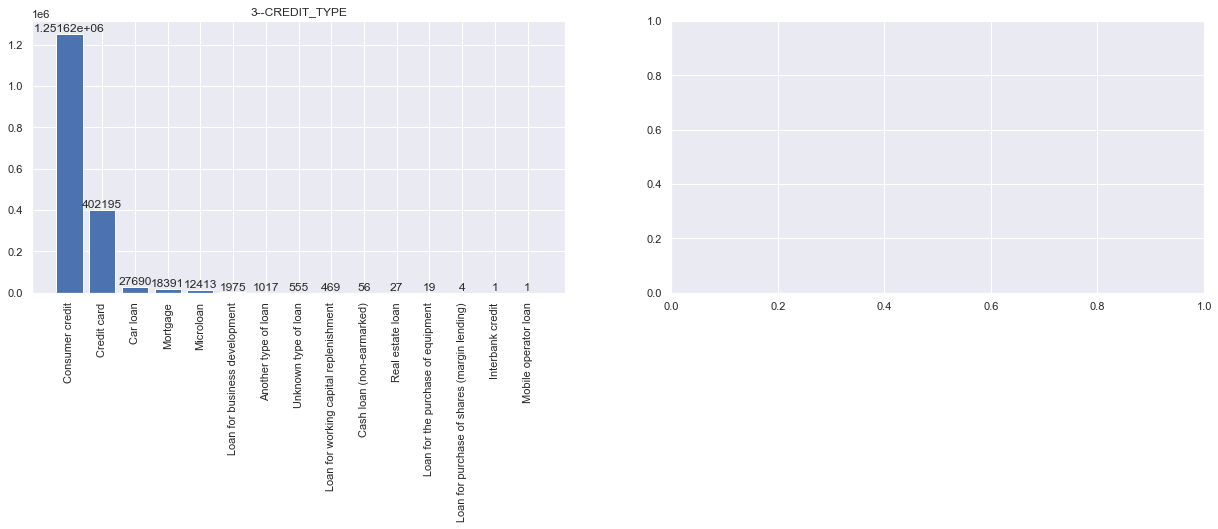

In [22]:
cat_cols_bureau=list(bur.select_dtypes('category').columns)

plot_categorical(bur, cat_cols_bureau, 2, 90)

Now we finally aggregate. Again, categorical and numeric columns must be treated separately. I'll create 2 functions for them.

In [23]:
def numeric_agg(df, group_col, df_name):
    num_df=df.select_dtypes('number')
    if num_df.shape[1]!=0:
        for c in num_df.columns:
            if 'SK_ID' in c and c!=group_col:
                num_df=num_df.drop(c, axis=1)
        df_agg=num_df.groupby(group_col).agg(['count', 'mean', 'max', 'min', 'sum'])

        new_cols=[]
        for l1 in df_agg.columns.levels[0]:
            if l1!=group_col:
                for l2 in df_agg.columns.levels[1]: # for stat in agg.columns.levels[1][:-1]
                    new_cols.append(f'{df_name}_{l1}_{l2}')
        df_agg.columns=new_cols
        # Remove duplicate columns by values
        _, idx = np.unique(df_agg, axis = 1, return_index = True)
        df_agg = df_agg.iloc[:, idx]
        print(f'Dataset:{df_name}\n\tBefore: {num_df.shape[1]} numeric cols\n\tAfter: {df_agg.shape[1]}')
        return df_agg
    else:
        print('No numeric columns in dataframe')
        return False

In [24]:
def categ_agg(df, group_col, df_name, enc, enc_mode='train'):
    cat_df=df.select_dtypes(include=['category', 'object'])
    if cat_df.shape[1]!=0:
        if enc_mode=='train':
            cat_df_ohe=enc.fit_transform(cat_df)
        elif enc_mode=='test': 
            cat_df_ohe=enc.transform(cat_df)
        cat_df_ohe=pd.DataFrame(cat_df_ohe, columns=enc.get_feature_names_out())
        cat_df_ohe[group_col]=df[group_col]
        df_agg=cat_df_ohe.groupby(group_col).agg(['sum', 'mean'])

        new_cols=[]
        for l1 in df_agg.columns.levels[0]:
            for l2 in ['count', 'count_norm']: # more suitable aliases for sum and mean
                new_cols.append(f'{df_name}_{l1}_{l2}')
        df_agg.columns=new_cols
        # Remove duplicate columns by values
        _, idx = np.unique(df_agg, axis = 1, return_index = True)
        df_agg = df_agg.iloc[:, idx]
        print(f'Dataset:{df_name}\n\tBefore: {cat_df.shape[1]} categorical cols\n\tAfter: {df_agg.shape[1]}')
        return df_agg
    else:
        print('No categorical columns in dataframe')
        return False

In [25]:
bur_numeric_agg_df=numeric_agg(bur, 'SK_ID_CURR', 'bureau')
bur_numeric_agg_df.head()

Dataset:bureau
	Before: 13 numeric cols
	After: 56


,bureau_DAYS_CREDIT_sum,bureau_DAYS_ENDDATE_FACT_sum,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CREDIT_DAY_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_ANNUITY_min,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_DAYS_ENDDATE_FACT_count,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_DAYS_CREDIT_ENDDATE_count,bureau_AMT_ANNUITY_count,bureau_AMT_CREDIT_SUM_count,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_CREDIT_ENDDATE_max,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-3302.0000,-1572,-1329.0000,-1328.0000,-825.5000,-735.0000,-652,-544.0000,-155,-93.1429,-49,-6,0,0,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,4,6,7,7,7,7,7,82.4286,577.0000,1778.0000,3545.3572,10822.5000,24817.5000,85240.9297,85500.0000,207623.5781,373239.0000,378000.0000,596686.5000,1453365.0000,NaN,NaN,NaN
100002,-6992,-4185.0000,-1437,-1072.0000,-1185.0000,-697.5000,-874.0000,-3999,-36.0000,-1185,-499.8750,-103,-7,0,0,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,5,7997.1411,8405.1445,31988.5645,31988.5645,6,4,5,6,7,8,8,-349.0000,-2094.0000,780.0000,0.0000,0.0000,0.0000,49156.1992,0.0000,108131.9453,245781.0000,450000.0000,245781.0000,865055.5625,0.0000,1681.0291,5043.6450
100003,-5603,-3292.0000,-2586,-2434.0000,-2131.0000,-1097.3334,-1400.7500,-3264,-540.0000,-2131,-816.0000,-606,-43,0,0,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,0.0000,0,0,0.0000,0.0000,NaN,4,202500.0000,0.0000,810000.0000,810000.0000,3,4,4,4,0,4,4,-544.5000,-2178.0000,1216.0000,NaN,NaN,0.0000,0.0000,22248.0000,254350.1250,0.0000,810000.0000,0.0000,1017400.5000,0.0000,0.0000,0.0000
100004,-1734,-1065.0000,-1326,-595.0000,-683.0000,-532.5000,-867.0000,-1064,-382.0000,-682,-532.0000,-408,-382,0,0,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,0.0000,0,0,0.0000,0.0000,NaN,1,0.0000,0.0000,0.0000,0.0000,2,2,2,2,0,2,2,-488.5000,-977.0000,-382.0000,NaN,NaN,0.0000,0.0000,94500.0000,94518.8984,0.0000,94537.7969,0.0000,189037.7969,0.0000,0.0000,0.0000
100005,-572,-123.0000,-373,-128.0000,-123.0000,-123.0000,-190.6667,-163,-123.0000,-121,-54.3333,-62,-11,0,0,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,0.0000,0,0,0.0000,0.0000,0.0000,1,0.0000,0.0000,0.0000,0.0000,1,3,3,3,3,3,3,439.3333,1318.0000,1324.0000,1420.5000,4261.5000,4261.5000,189469.5000,29826.0000,219042.0000,543087.0000,568800.0000,568408.5000,657126.0000,0.0000,0.0000,0.0000


In [26]:
bur_ohe=OneHotEncoder(handle_unknown='ignore', sparse=False)

bur_categ_agg_df=categ_agg(bur, 'SK_ID_CURR', 'bureau', bur_ohe)
bur_categ_agg_df.head()

Dataset:bureau
	Before: 3 categorical cols
	After: 46


,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_CURRENCY_currency 1_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4286,0.5714,1.0000,1.0000,3.0000,4.0000,7.0000,7.0000
100002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,4.0000,0.2500,0.7500,0.5000,1.0000,2.0000,6.0000,4.0000,8.0000
100003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,2.0000,0.2500,0.7500,0.5000,1.0000,1.0000,3.0000,2.0000,4.0000
100004,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000,0.0000,2.0000,2.0000,2.0000
100005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,1.0000,0.6667,0.3333,0.6667,1.0000,2.0000,1.0000,2.0000,3.0000


I aggregated previous credits by `SK_ID_CURR`, which is ID of a loan (recall that one loan in application data can have lots of previous credits in bureau data). I can merge these categorical and numeric dataframes with application data by `SK_ID_CURR`.

`bureau_balance` is a bit tricky, as you must aggregate it 2 times. First, you aggregate by `SK_ID_BURR` (again, here one previous credit has many records). Then, you aggregate again by `SK_ID_CURR` (include it beforehand), so later you can merge with application data.

In [27]:
bb_numeric_agg_df=numeric_agg(bb, 'SK_ID_BUREAU', 'bureau_balance')
bb_numeric_agg_df.head()

Dataset:bureau_balance
	Before: 2 numeric cols
	After: 5


,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_count
SK_ID_BUREAU,,,,,
5001709,-4656,-96,-48.0000,0,97
5001710,-3403,-82,-41.0000,0,83
5001711,-6,-3,-1.5000,0,4
5001712,-171,-18,-9.0000,0,19
5001713,-231,-21,-10.5000,0,22


In [28]:
bb_ohe=OneHotEncoder(handle_unknown='ignore', sparse=False)

bb_categ_agg_df=categ_agg(bb, 'SK_ID_BUREAU', 'bureau_balance', bb_ohe)
bb_categ_agg_df.head()

Dataset:bureau_balance
	Before: 1 categorical cols
	After: 16


,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_3_count,bureau_balance_STATUS_2_count,bureau_balance_STATUS_5_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_0_count,bureau_balance_STATUS_X_count_norm,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_C_count
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1134,0.8866,11.0000,86.0000
5001710,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0602,5.0000,0.3614,0.5783,30.0000,48.0000
5001711,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7500,3.0000,0.2500,0.0000,1.0000,0.0000
5001712,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5263,10.0000,0.0000,0.4737,0.0000,9.0000
5001713,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,22.0000,0.0000


In [29]:
bb_full=bb_numeric_agg_df.merge(bb_categ_agg_df, on='SK_ID_BUREAU', how='outer') # combine categ and numeric

bb_by_credit=bur[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bb_full, on='SK_ID_BUREAU', how='left') # add SK_ID_CURR
bb_by_loan=numeric_agg(bb_by_credit, 'SK_ID_CURR', 'loan') # aggregate by loan

Dataset:loan
	Before: 22 numeric cols
	After: 85


Finally, all these dataframes can be merged together.

In [30]:
app_train=app_train_domain.merge(bur_numeric_agg_df, on='SK_ID_CURR', how='left') # numeric features from bureas

app_train=app_train.merge(bur_categ_agg_df, on='SK_ID_CURR', how='left') # categorical feautures from bureau

app_train=app_train.merge(bb_by_loan, on='SK_ID_CURR', how='left') # all features from bureau_balance

In [31]:
print(f'Train data shape after adding all bureau and domain: {app_train.shape}')

Train data shape after adding all bureau and domain: (307511, 353)


In [32]:
gc.enable()
del bur_numeric_agg_df, bur_categ_agg_df, bb_categ_agg_df, bb_numeric_agg_df, bb_full, bb_by_credit, bb_by_loan, bur, bb
gc.collect()

30

Dataset starts to get 'wider' (it'll be 1000+ features and the end of FE). Let's quickly throw this new dataframe to LightGBM, maybe we'll get even higher AUC?

In [33]:
res, importances=quick_cv(app_train)
res

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	train's auc: 0.84577	test's auc: 0.771483
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	train's auc: 0.845763	test's auc: 0.774987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	train's auc: 0.829518	test's auc: 0.768449
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	train's auc: 0.832082	test's auc: 0.773746
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	train's auc: 0.85365	test's auc: 0.774245


,Train AUC,Test AUC
0,0.8458,0.7715
1,0.8458,0.7750
2,0.8295,0.7684
3,0.8321,0.7737
4,0.8536,0.7742
Avg,0.8414,0.7726


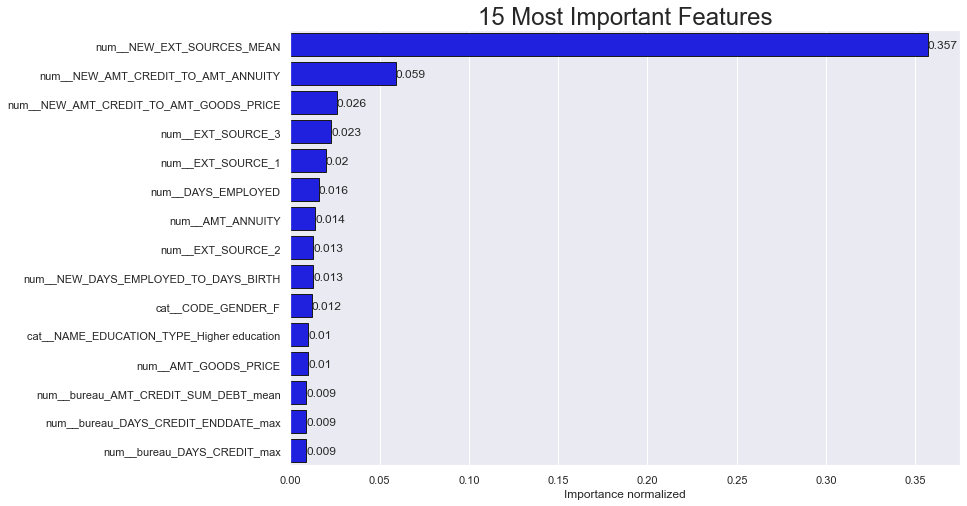

In [34]:
plot_feat_imp(importances, 15)

Well, there is some improvement of test AUC. But notice that, cumpared to `app_train_domain` results, train AUC rise is higher than in the test AUC. Maybe, the model begins to overfit here.

## Previous applications

`previous_application.csv` contains all previous applications to Home Credit (no surprices here). One sample from application data can have many previous applications. Hence, need to aggregate again.

In [35]:
previous=pd.read_csv('../data/previous_application.csv')
previous=convert_types(previous)
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.4301,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,Y,True,0.0000,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0000,middle,POS mobile with interest,365243.0000,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,Cash loans,25188.6152,607500.0000,679671.0000,NaN,607500.0000,THURSDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0000,low_action,Cash X-Sell: low,365243.0000,-134.0000,916.0000,365243.0000,365243.0000,1.0000
2,2523466,122040,Cash loans,15060.7354,112500.0000,136444.5000,NaN,112500.0000,TUESDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,high,Cash X-Sell: high,365243.0000,-271.0000,59.0000,365243.0000,365243.0000,1.0000
3,2819243,176158,Cash loans,47041.3359,450000.0000,470790.0000,NaN,450000.0000,MONDAY,7,Y,True,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,middle,Cash X-Sell: middle,365243.0000,-482.0000,-152.0000,-182.0000,-177.0000,1.0000
4,1784265,202054,Cash loans,31924.3945,337500.0000,404055.0000,NaN,337500.0000,THURSDAY,9,Y,True,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


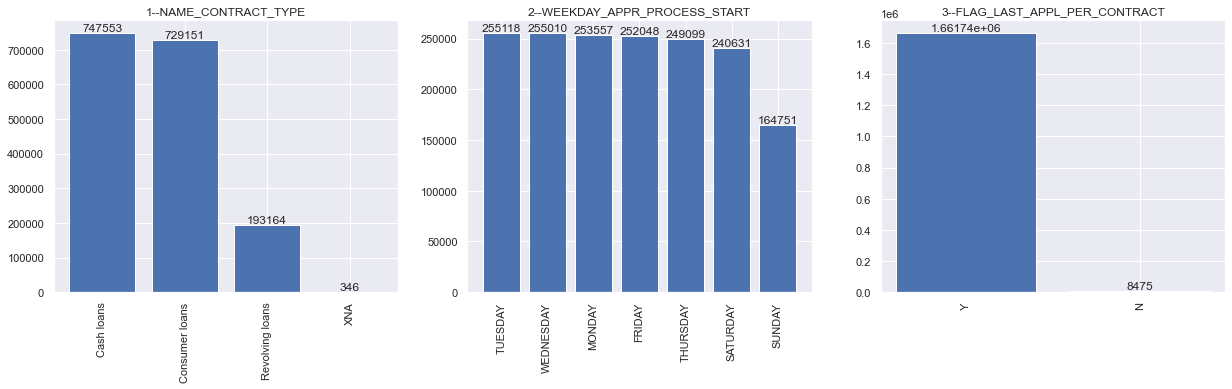

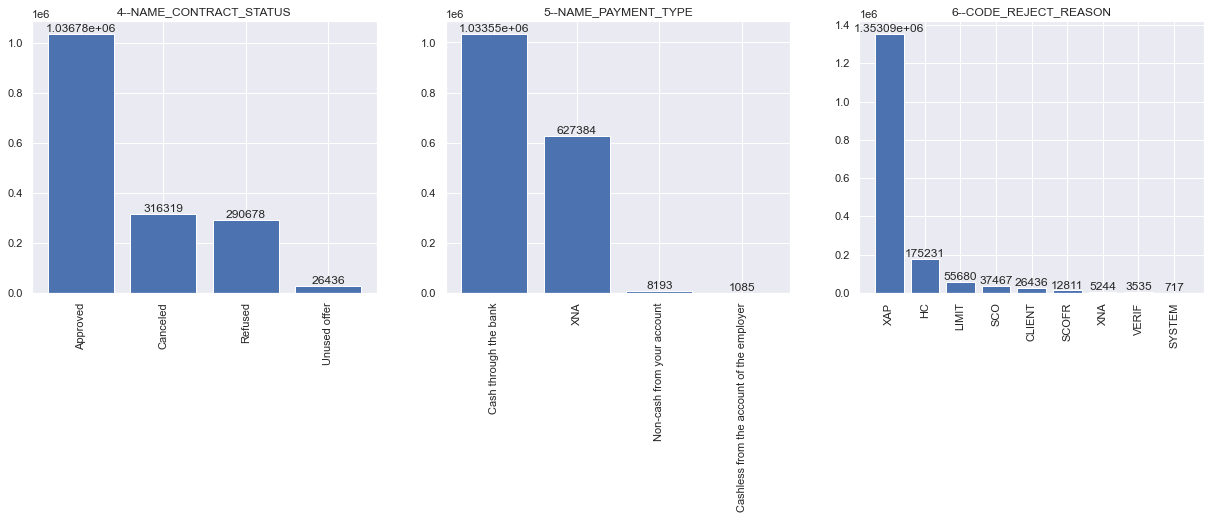

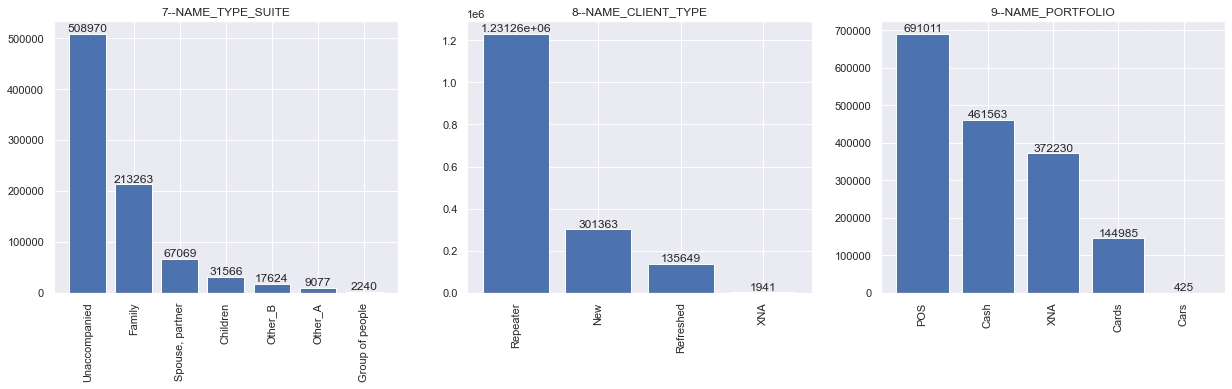

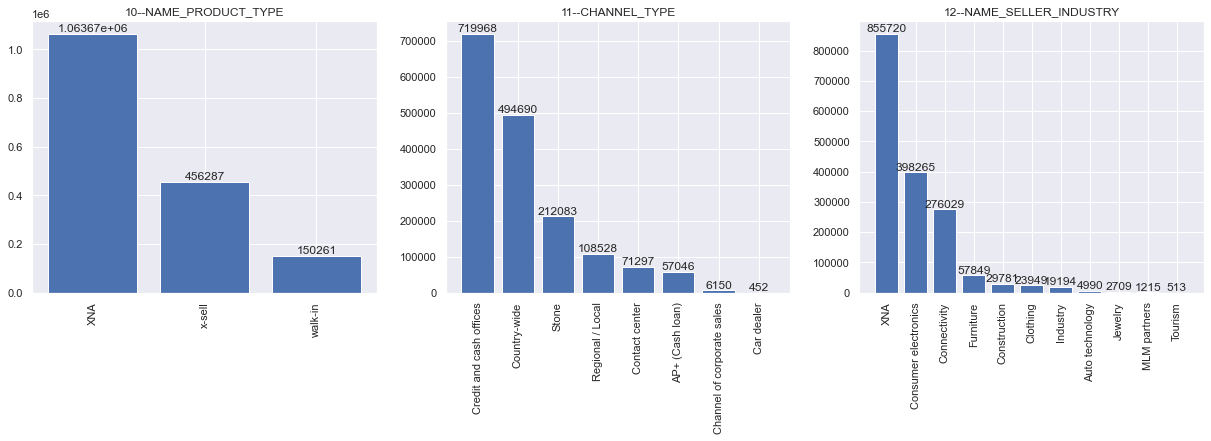

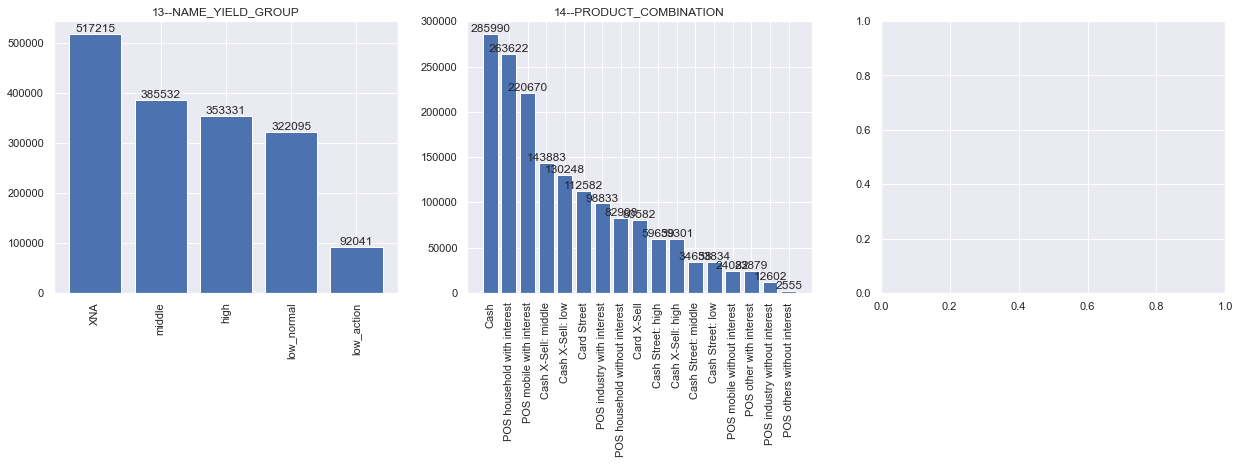

In [36]:
prev_cat_cols=list(previous.drop(['NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY'], axis=1).select_dtypes('category'))

plot_categorical(previous, prev_cat_cols, 3, 90)

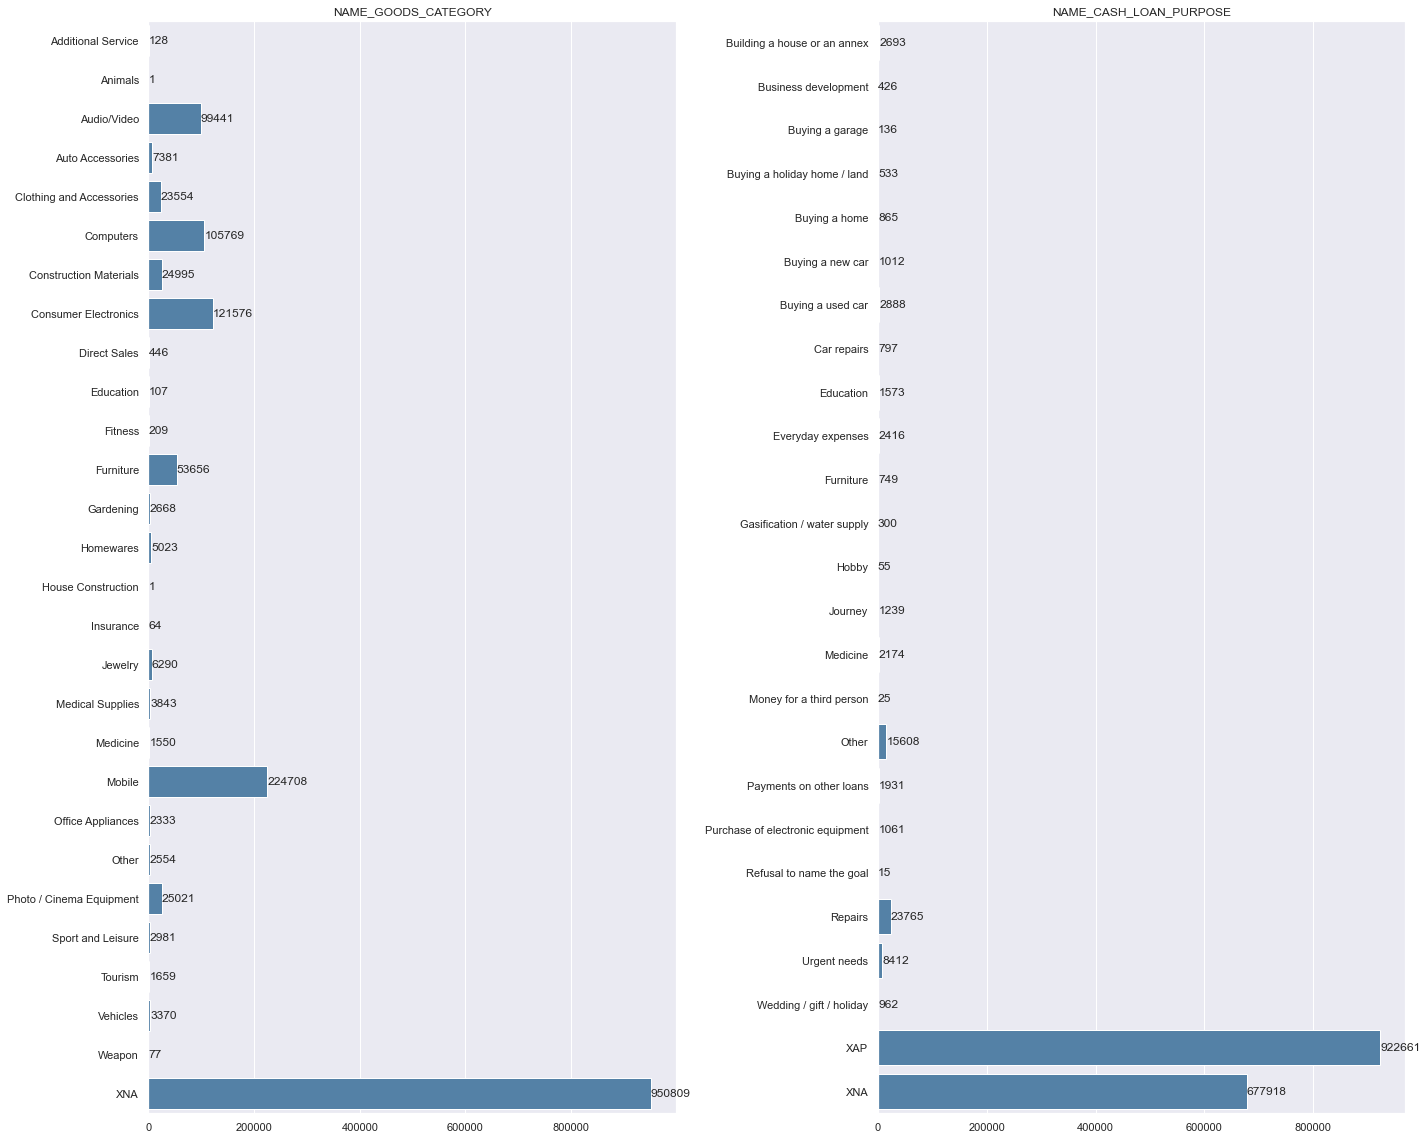

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 16))

vc=previous['NAME_GOODS_CATEGORY'].value_counts()
g=sns.barplot(y=vc.index, x=vc.values, orient='horizontal',color='steelblue', ax=axes[0])
axes[0].set_title('NAME_GOODS_CATEGORY')
for i in g.containers:
    g.bar_label(i,)

vc=previous['NAME_CASH_LOAN_PURPOSE'].value_counts()
g=sns.barplot(y=vc.index, x=vc.values, orient='horizontal',color='steelblue', ax=axes[1])
axes[1].set_title('NAME_CASH_LOAN_PURPOSE')
for i in g.containers:
    g.bar_label(i,)

fig.tight_layout()

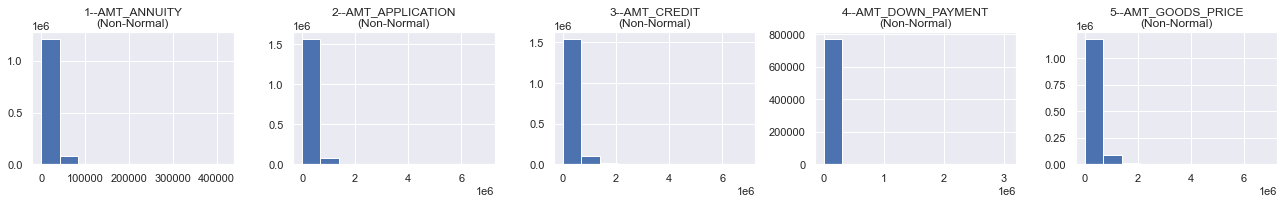

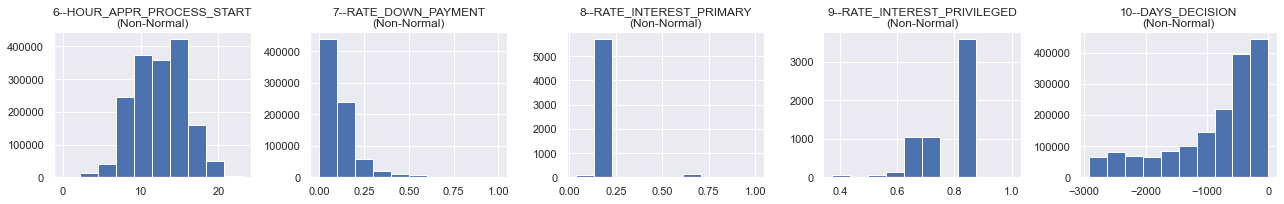

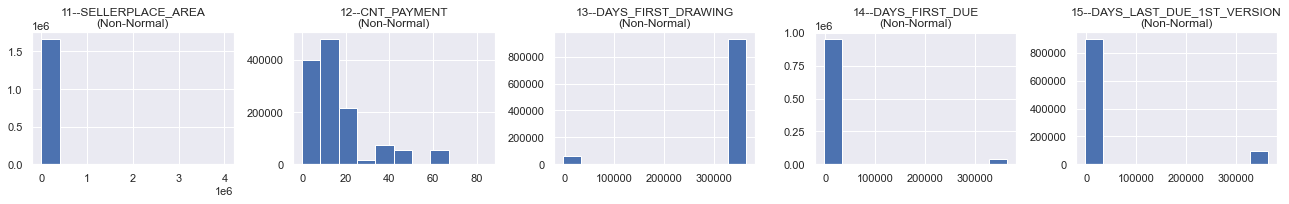

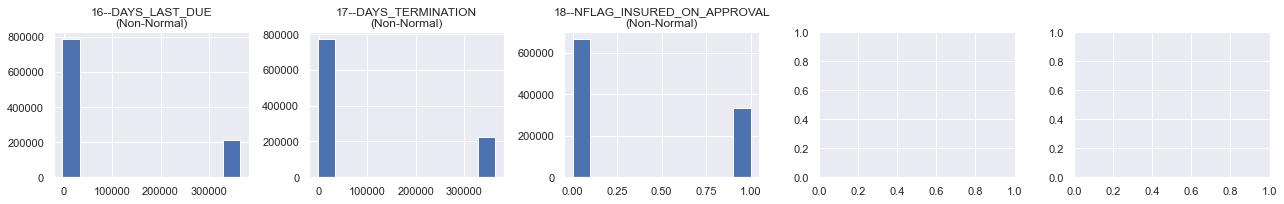

In [38]:
prev_numeric_cols=list(previous.drop(['SK_ID_PREV', 'SK_ID_CURR'], axis=1).select_dtypes('number'))

plot_numeric(previous, prev_numeric_cols, 5)

Again, some weird 1000-ish years values in several columns. `DAYS_FIRST_DRAWING` variable is particularly distorted, one may even drop it entirely.

In [39]:
for c in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    previous[c].replace(365243, np.nan, inplace=True)

In [40]:
def agg_combine(df, group_vars, df_names, enc, enc_mode='train', agg_level=1):
    if agg_level==2:
        df_cat_agg=categ_agg(df, group_vars[1], df_names[1], enc, enc_mode)
        df_num_agg=numeric_agg(df, group_vars[1], df_names[1])
        df_full_l2=df_cat_agg.merge(df_num_agg, on=group_vars[1], how='outer')
        df_full_l2=df[group_vars].merge(df_full_l2, on=group_vars[1], how='right')
        df_full=numeric_agg(df_full_l2, group_vars[0], df_names[0])
        gc.enable()
        del df_full_l2
        gc.collect()
    elif agg_level==1:
        df_cat_agg=categ_agg(df, group_vars[0], df_names[0], enc, enc_mode)
        df_num_agg=numeric_agg(df, group_vars[0], df_names[0])
        df_full=df_cat_agg.merge(df_num_agg, on=group_vars[0], how='outer')
    else:
        return 'Select aggregation level 1 or 2'
    gc.enable()
    del df_cat_agg, df_num_agg
    gc.collect()
    return df_full

In [41]:
prev_ohe=OneHotEncoder(handle_unknown='ignore', sparse=False)

prev_full=agg_combine(previous, ['SK_ID_CURR'], ['previous'], prev_ohe)

Dataset:previous
	Before: 16 categorical cols
	After: 286
Dataset:previous
	Before: 19 numeric cols
	After: 85


In [42]:
app_train=app_train.merge(prev_full, on='SK_ID_CURR', how='left')

In [43]:
gc.enable()
del prev_full, previous
gc.collect()

15

## Cash

In [44]:
cash=pd.read_csv('../data/POS_CASH_balance.csv')
cash=convert_types(cash)
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0000,45.0000,Active,0,0
1,1715348,367990,-33,36.0000,35.0000,Active,0,0
2,1784872,397406,-32,12.0000,9.0000,Active,0,0
3,1903291,269225,-35,48.0000,42.0000,Active,0,0
4,2341044,334279,-35,36.0000,35.0000,Active,0,0


In [45]:
cash_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
cash_full=agg_combine(cash, ['SK_ID_CURR', 'SK_ID_PREV'], ['loan', 'cash'], cash_ohe, agg_level=2)

Dataset:cash
	Before: 1 categorical cols
	After: 18
Dataset:cash
	Before: 6 numeric cols
	After: 23
Dataset:loan
	Before: 42 numeric cols
	After: 162


In [46]:
app_train=app_train.merge(cash_full, on='SK_ID_CURR', how='left')

In [47]:
gc.enable()
del cash_full, cash
gc.collect()

15

## Installments

In this dataframe there is only numeric data, so `numeric_agg` is enough.

In [48]:
inst=pd.read_csv('../data/installments_payments.csv')
inst=convert_types(inst)
inst.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0000,6,-1180.0000,-1187.0000,6948.3599,6948.3599
1,1330831,151639,0.0000,34,-2156.0000,-2156.0000,1716.5250,1716.5250
2,2085231,193053,2.0000,1,-63.0000,-63.0000,25425.0000,25425.0000
3,2452527,199697,1.0000,3,-2418.0000,-2426.0000,24350.1309,24350.1309
4,2714724,167756,1.0000,2,-1383.0000,-1366.0000,2165.0400,2160.5850


In [49]:
inst_agg_by_prev=numeric_agg(inst, 'SK_ID_PREV', 'inst')
inst_agg_by_prev=inst[['SK_ID_PREV', 'SK_ID_CURR']].merge(inst_agg_by_prev, on='SK_ID_PREV', how='right')
inst_agg_by_loan=numeric_agg(inst_agg_by_prev, 'SK_ID_CURR', 'loan')

Dataset:inst
	Before: 7 numeric cols
	After: 26
Dataset:loan
	Before: 27 numeric cols
	After: 106


In [50]:
app_train=app_train.merge(inst_agg_by_loan, on='SK_ID_CURR', how='left')

In [51]:
import gc
gc.enable()
del inst, inst_agg_by_loan, inst_agg_by_prev
gc.collect()

15

## Card Balance

In [52]:
card_balance=pd.read_csv('../data/credit_card_balance.csv')
card_balance=convert_types(card_balance)
card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.9700,135000,0.0000,877.5000,0.0000,877.5000,1700.3250,1800.0000,1800.0000,0.0000,0.0000,0.0000,0.0000,1,0.0000,1.0000,35.0000,Active,0,0
1,2582071,363914,-1,63975.5547,45000,2250.0000,2250.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,60175.0781,64875.5547,64875.5547,1.0000,1,0.0000,0.0000,69.0000,Active,0,0
2,1740877,371185,-7,31815.2246,450000,0.0000,0.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,26926.4258,31460.0859,31460.0859,0.0000,0,0.0000,0.0000,30.0000,Active,0,0
3,1389973,337855,-4,236572.1094,225000,2250.0000,2250.0000,0.0000,0.0000,11795.7598,11925.0000,11925.0000,224949.2812,233048.9688,233048.9688,1.0000,1,0.0000,0.0000,10.0000,Active,0,0
4,1891521,126868,-1,453919.4688,450000,0.0000,11547.0000,0.0000,11547.0000,22924.8906,27000.0000,27000.0000,443044.4062,453919.4688,453919.4688,0.0000,1,0.0000,1.0000,101.0000,Active,0,0


In [53]:
card_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
card_full=agg_combine(card_balance, ['SK_ID_CURR', 'SK_ID_PREV'], ['loan', 'card'], card_ohe, agg_level=2)

Dataset:card
	Before: 1 categorical cols
	After: 14
Dataset:card
	Before: 21 numeric cols
	After: 83
Dataset:loan
	Before: 98 numeric cols
	After: 376


In [54]:
app_train=app_train.merge(card_full, on='SK_ID_CURR', how='left')

In [55]:
import gc
gc.enable()
del card_balance, card_full
gc.collect()

15

That's it! All data from all files is aggregated and attached to train. Now I'll check how many columns are there, save teh final dataset and feed this huge dataset to LightGBM.

In [57]:
app_train.shape

(307511, 1368)

In [58]:
app_train.to_csv('../data/full_train.csv', chunksize=500, index=False)

In [60]:
res, importances=quick_cv(app_train)
res

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	train's auc: 0.876076	test's auc: 0.786176
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	train's auc: 0.852915	test's auc: 0.789412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	train's auc: 0.872664	test's auc: 0.784103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	train's auc: 0.852409	test's auc: 0.787621
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[436]	train's auc: 0.879082	test's auc: 0.787752


,Train AUC,Test AUC
0,0.8761,0.7862
1,0.8529,0.7894
2,0.8727,0.7841
3,0.8524,0.7876
4,0.8791,0.7878
Avg,0.8666,0.7870


This is the final form of the dataset. The performance is pretty good, but teh dataset itself is too "wide". We could get rid of many features and still keep (almost) the same performance. For this, one needs FEature Selection, which will be done in next notebook.